In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

In [2]:
# Load dataset
data=pd.read_csv("D:\\LoanTap\\LoanTap\\artifacts\\data_ingestion\\LoanTap.csv")
df = data.copy()
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [3]:
# shape of data
df.shape

(210142, 27)

In [4]:
## Basic info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210142 entries, 0 to 210141
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             210142 non-null  float64
 1   term                  210142 non-null  object 
 2   int_rate              210142 non-null  float64
 3   installment           210142 non-null  float64
 4   grade                 210142 non-null  object 
 5   sub_grade             210142 non-null  object 
 6   emp_title             198020 non-null  object 
 7   emp_length            200425 non-null  object 
 8   home_ownership        210142 non-null  object 
 9   annual_inc            210142 non-null  float64
 10  verification_status   210142 non-null  object 
 11  issue_d               210141 non-null  object 
 12  loan_status           210141 non-null  object 
 13  purpose               210141 non-null  object 
 14  title                 209213 non-null  object 
 15  

In [5]:
#Basic stats 
df.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,210142.000000,210142.000000,210142.000000,2.101420e+05,210141.000000,210141.000000,210141.000000,2.101410e+05,209993.000000,210141.000000,190001.000000,209852.000000
mean,14094.437095,13.636186,431.279867,7.430756e+04,17.322776,11.306323,0.178870,1.581339e+04,53.757455,25.423030,1.814043,0.122272
std,8351.639881,4.461733,250.613065,6.029851e+04,8.131926,5.137542,0.514899,2.047085e+04,24.510515,11.898087,2.146586,0.356548
min,500.000000,5.320000,16.250000,2.500000e+03,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.260000,8.000000,0.000000,6.014000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.120000,6.400000e+04,16.880000,10.000000,0.000000,1.116500e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.040000,9.000000e+04,22.950000,14.000000,0.000000,1.960600e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,7.446395e+06,189.900000,90.000000,40.000000,1.743266e+06,892.300000,151.000000,34.000000,7.000000


In [6]:
## check null values
df.isna().sum()/len(df)*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.768480
emp_length              4.624016
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000476
loan_status             0.000476
purpose                 0.000476
title                   0.442082
dti                     0.000476
earliest_cr_line        0.000476
open_acc                0.000476
pub_rec                 0.000476
revol_bal               0.000476
revol_util              0.070904
total_acc               0.000476
initial_list_status     0.000476
application_type        0.000476
mort_acc                9.584471
pub_rec_bankruptcies    0.138002
address                 0.000476
dtype: float64

9.5% missing values in mort_acc column. Let's treat it later

In [7]:
## EDA and Feature engineering
# separate numerical and categorical columns for univariate analysis

numerical_columns = list(df.loc[:, df.dtypes!=object].columns)
categorical_columns = list(df.loc[:, df.dtypes==object].columns)



In [8]:
def plot_histogram_and_boxplot(df, columm):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    sns.histplot(data=df, x=columm, kde=True)
    plt.title(f"Distribution of {columm}")
    plt.subplot(1,2,2)
    sns.boxplot(data=df, x=columm)
    plt.title(f"Boxplot of {columm}")
    plt.show()


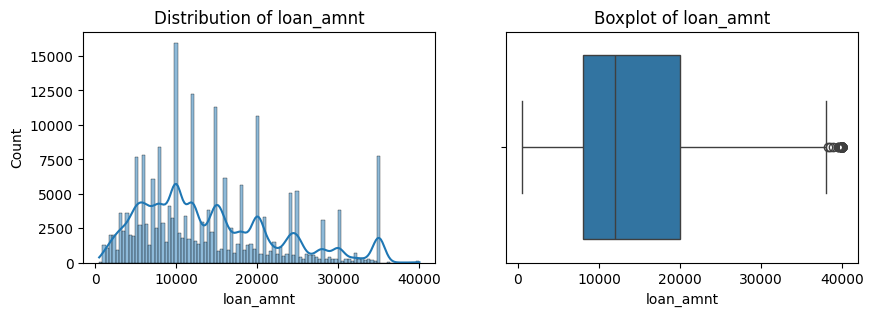

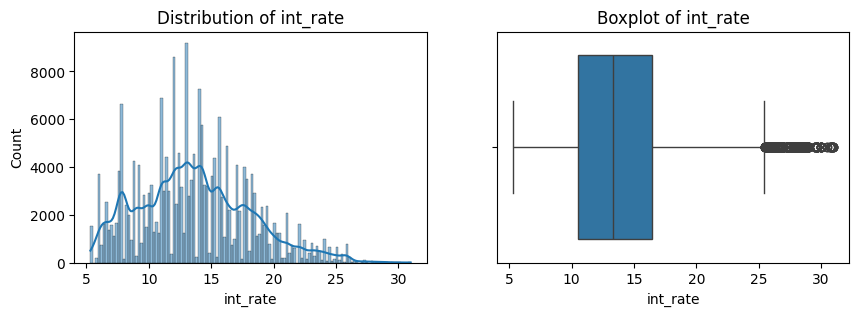

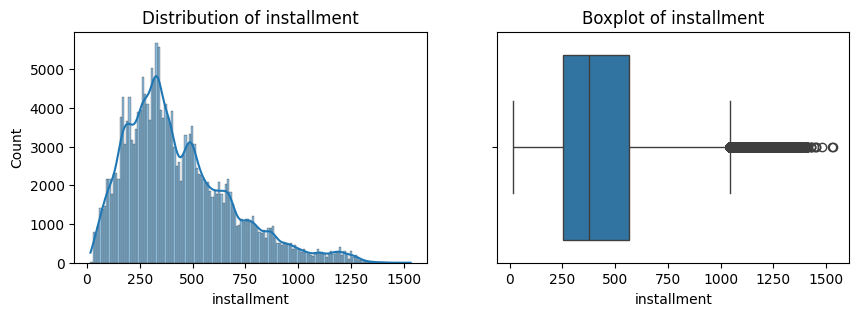

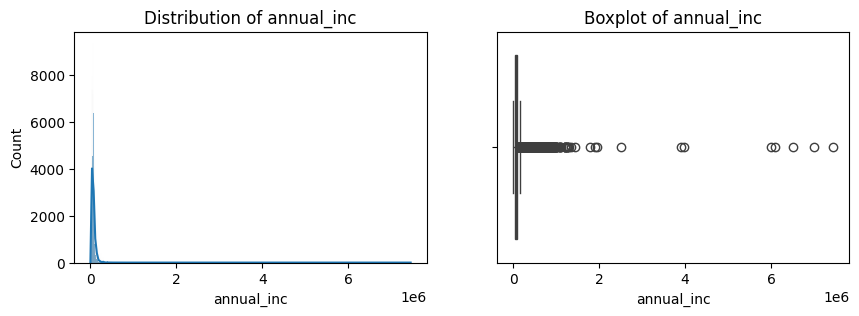

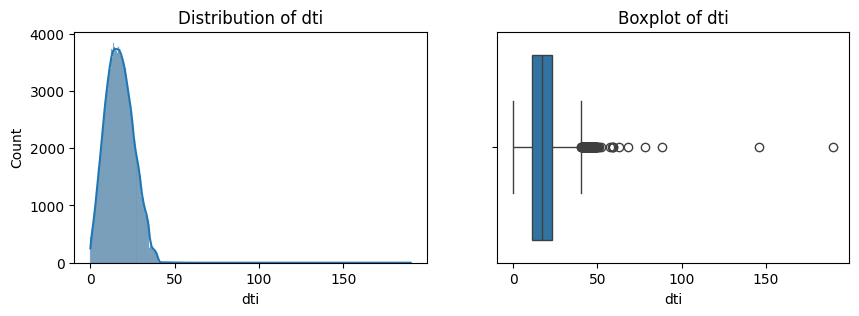

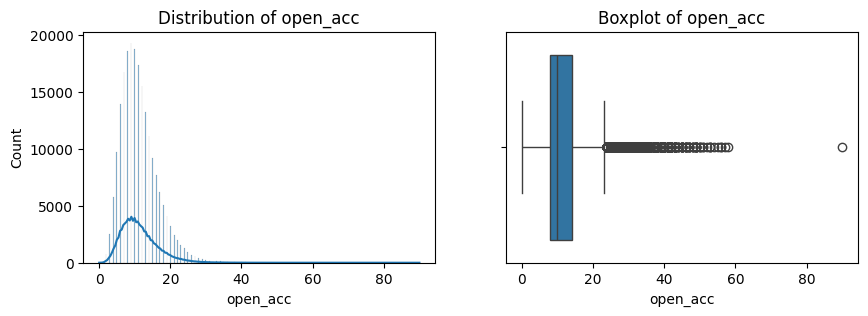

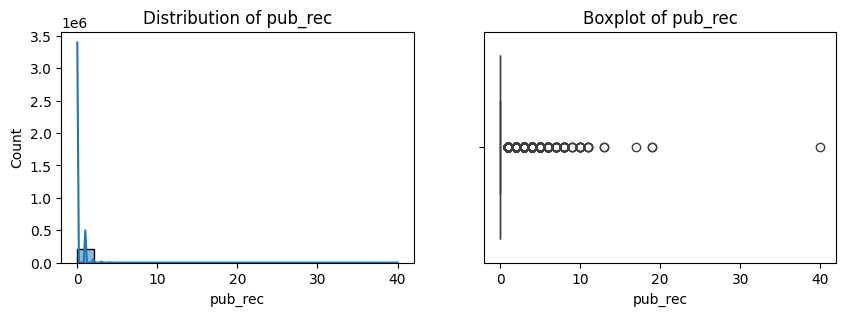

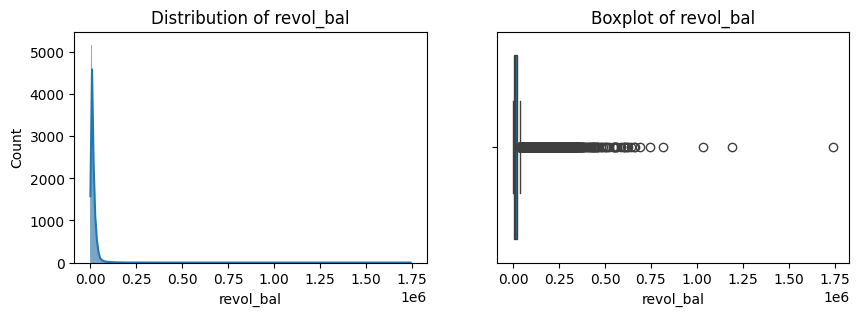

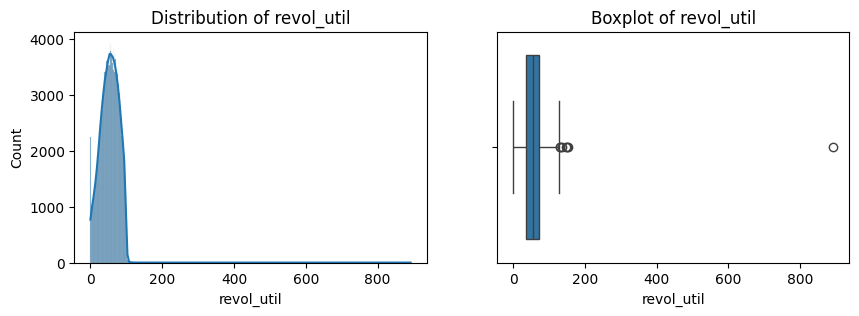

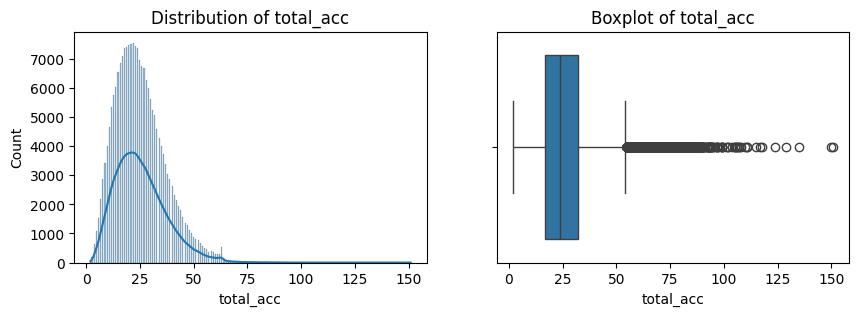

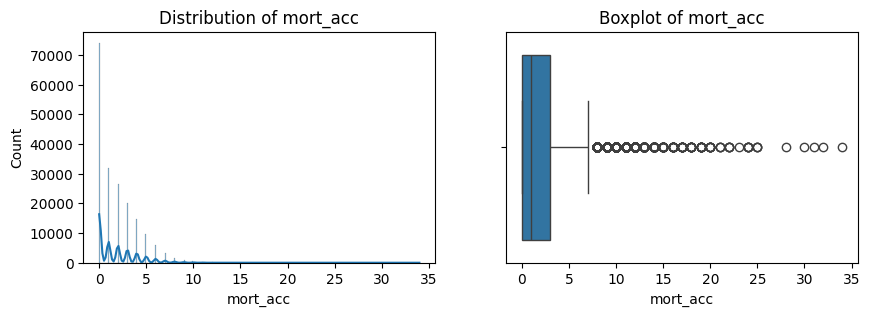

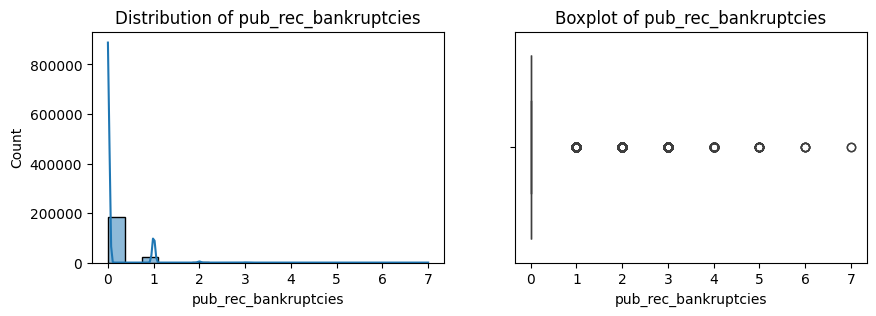

In [9]:
for col in numerical_columns:
    plot_histogram_and_boxplot(df, col)

In [8]:
## Even though data type of mort_acc and pub_rec_bankrupties have numerical data type they are categorical features.
## Let's append these columns to categorical data

categorical_columns.extend(['mort_acc','pub_rec_bankruptcies'])

In [9]:
# check number of categories in each featue
for col in categorical_columns:
    print(f"{col}-->{df[col].nunique()}")

term-->2
grade-->7
sub_grade-->35
emp_title-->101016
emp_length-->11
home_ownership-->6
verification_status-->4
issue_d-->115
loan_status-->2
purpose-->14
title-->28434
earliest_cr_line-->658
initial_list_status-->2
application_type-->3
address-->209391
mort_acc-->31
pub_rec_bankruptcies-->8


In [10]:
print(df['purpose'].unique())
print(df['title'].unique())

['vacation' 'debt_consolidation' 'credit_card' 'home_improvement'
 'small_business' 'major_purchase' 'other' 'medical' 'wedding' 'car'
 'moving' 'house' 'educational' 'renewable_energy' nan]
['Vacation' 'Debt consolidation' 'Credit card refinancing' ...
 'Consolidate Debt and Pay Taxes' 'Discover HSBC' 'paid credict card']


Purpose and Title have same data.
Let's drop title column as it has more categories due possibly to manual typing errors

In [11]:
df=df.drop(columns=['title'])

In [12]:
categorical_columns=['term',
                        'grade',
                        'sub_grade',
                        'emp_length',
                        'home_ownership',
                        'verification_status',
                        'purpose',
                        'initial_list_status',
                        'application_type',
                        'mort_acc',
                        'pub_rec_bankruptcies']

In [13]:
## plot univariate counts and count w.r.t target
def plot_countplot(df, col, target):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    sns.countplot(data=df, y=col,stat='percent')
    plt.title(f"count plot of {col}")
    plt.subplot(1,2,2)
    sns.countplot(data=df, y=col,hue=target,stat='percent')
    plt.title(f"count plot of {col} w.r.t {target} ")
    plt.show()

    


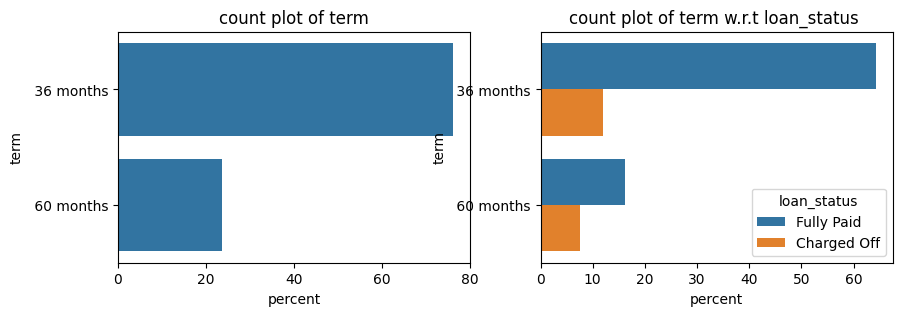

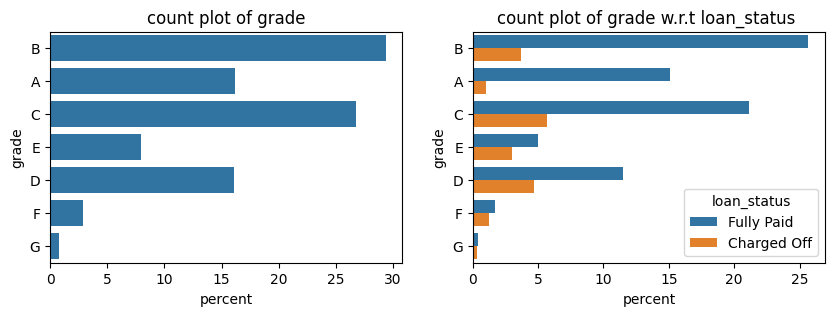

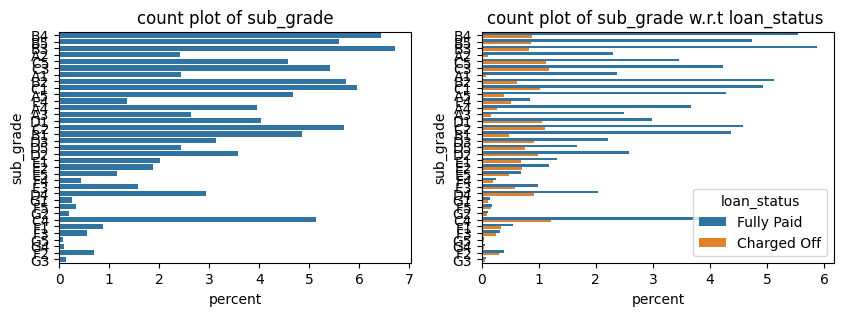

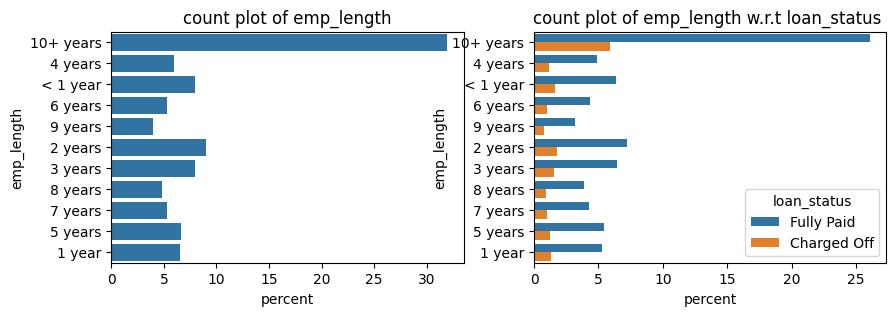

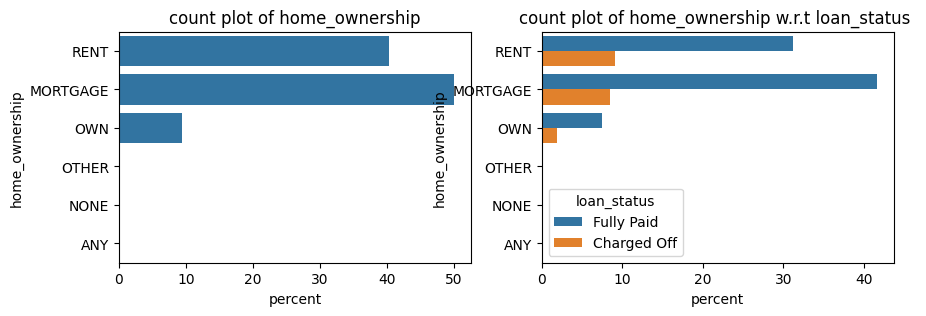

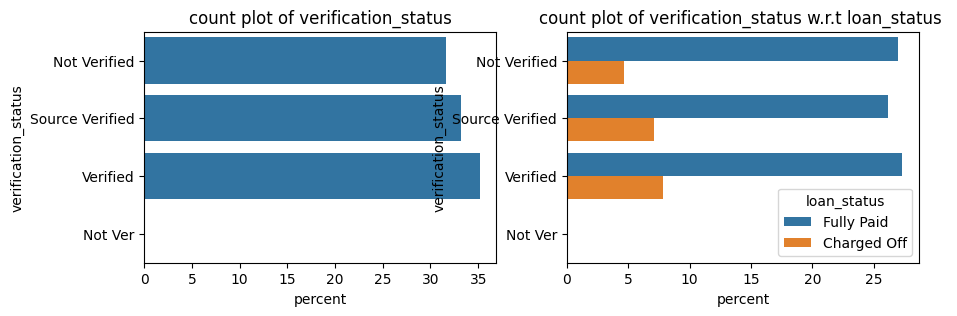

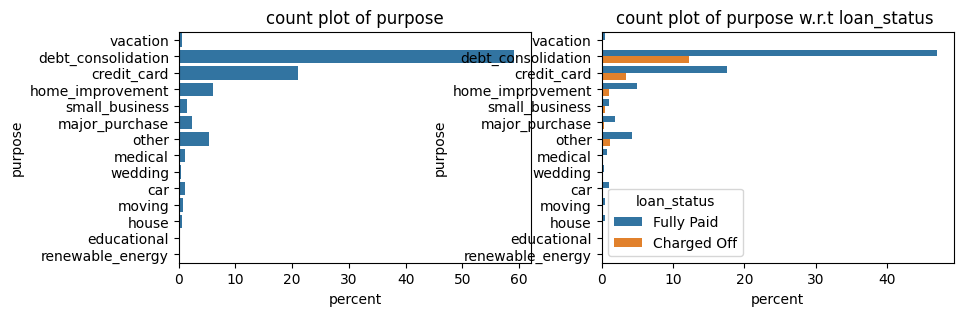

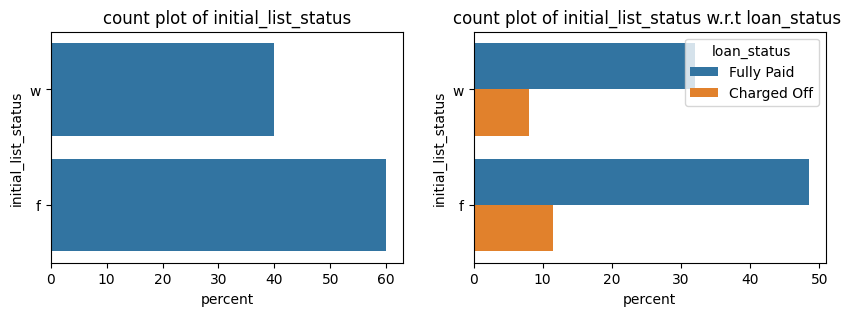

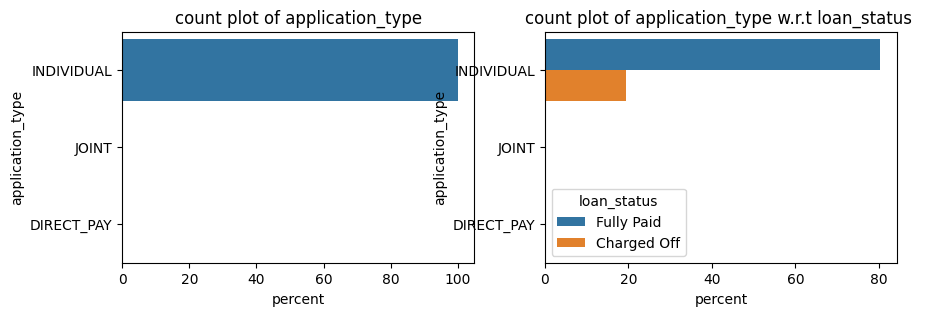

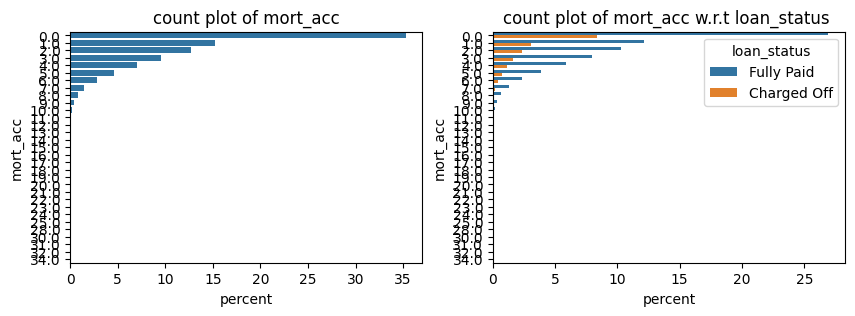

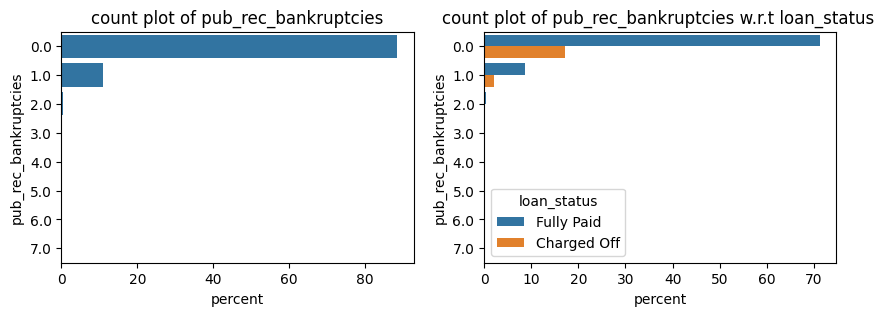

In [16]:
for col in categorical_columns:
    plot_countplot(df, col, 'loan_status')

In [17]:
## Bivariate analysis between numerical features and target
def plot_kdeplot(df, col, target):
    plt.figure(figsize=(10,3))
    sns.kdeplot(data=df, x=col,hue=target)
    plt.title(f"kde plot of {col} w.r.t {target}")
    plt.show()

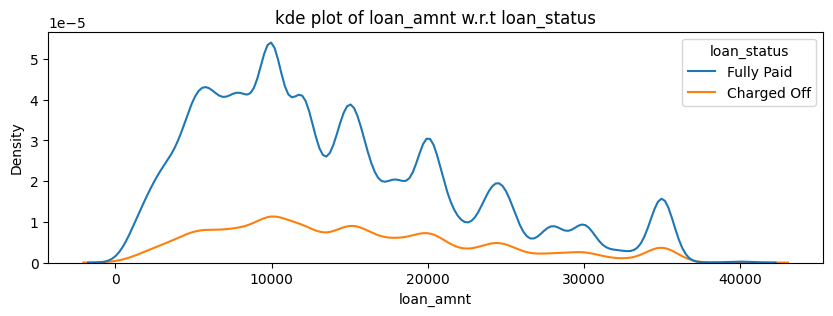

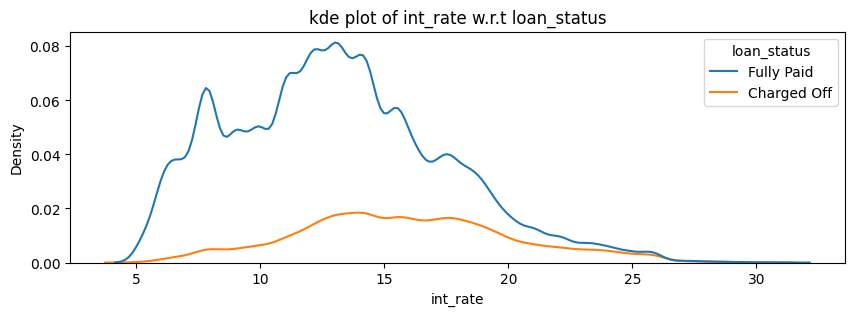

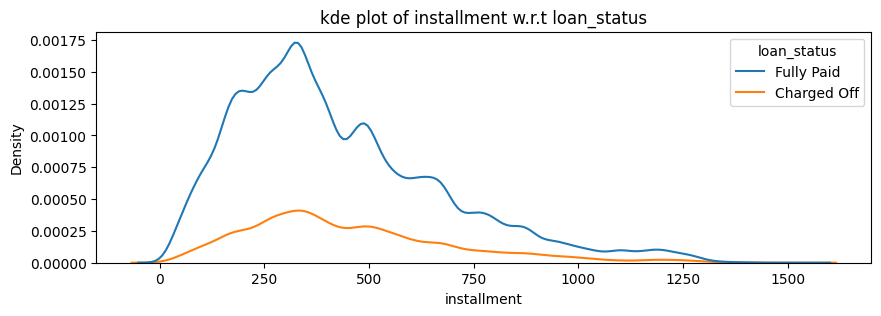

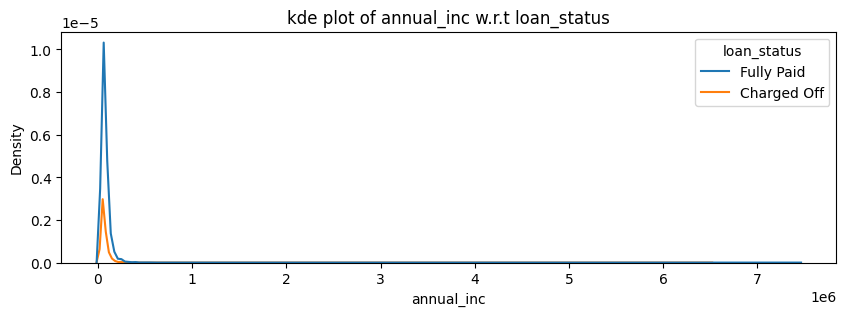

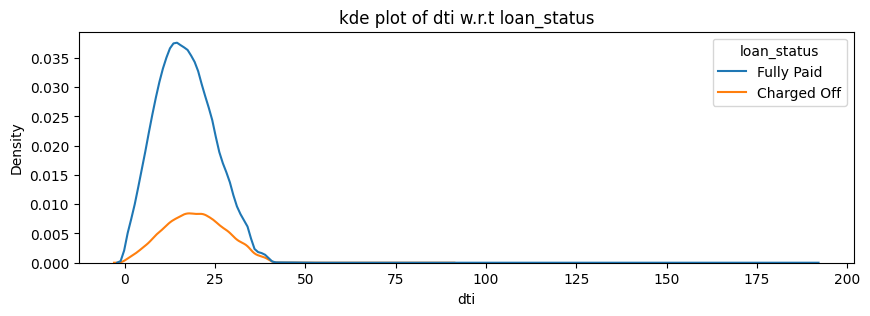

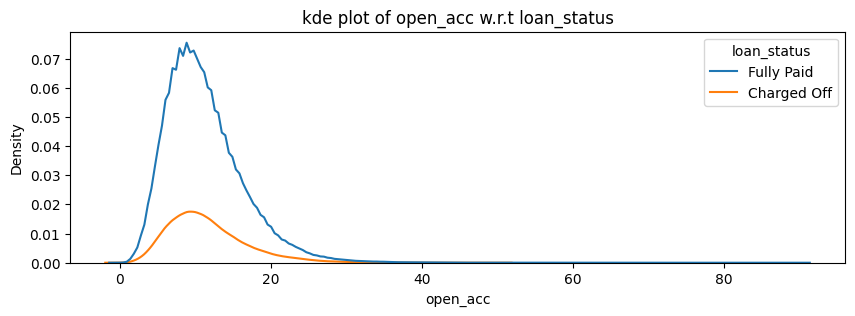

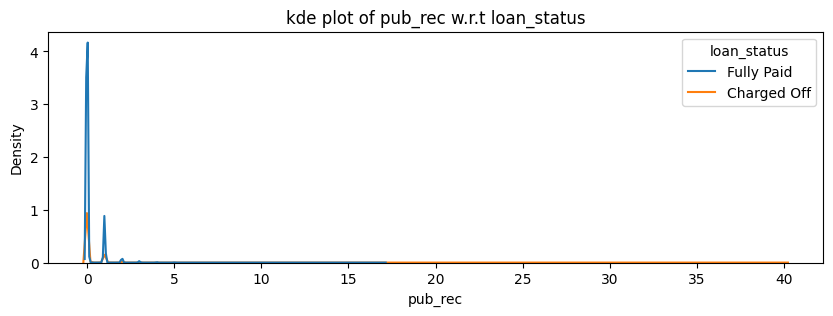

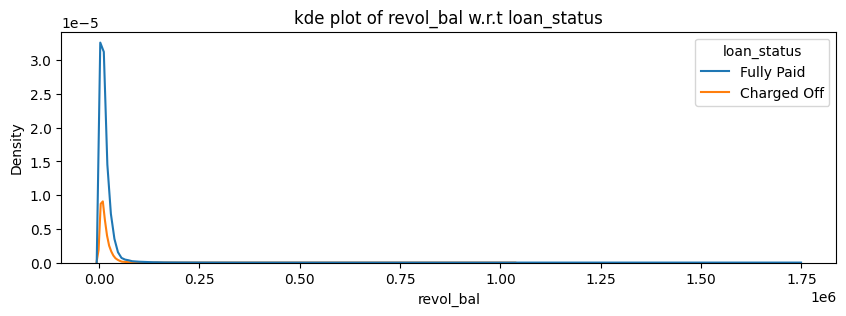

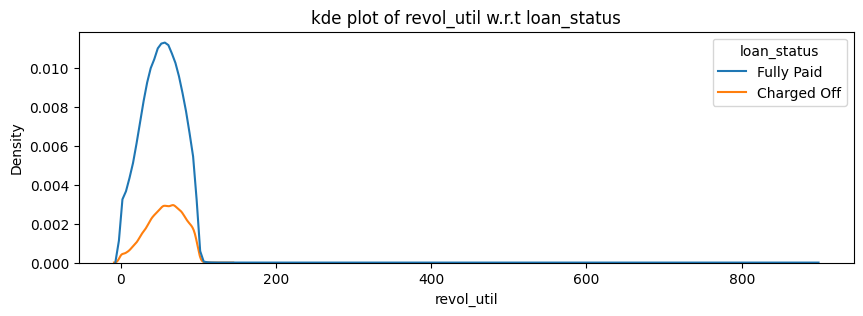

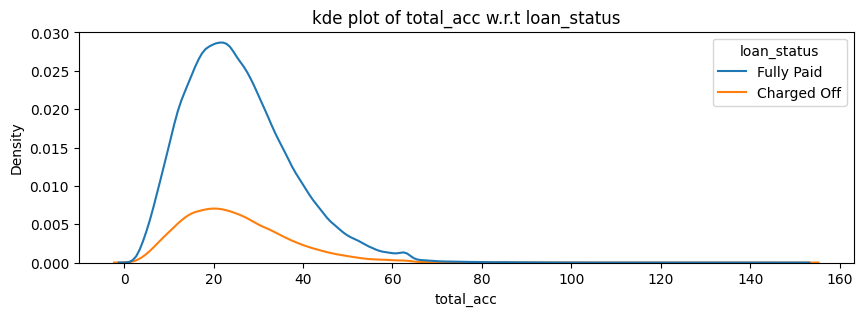

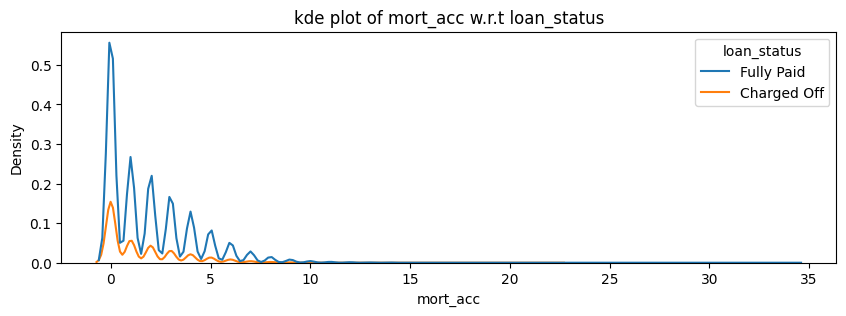

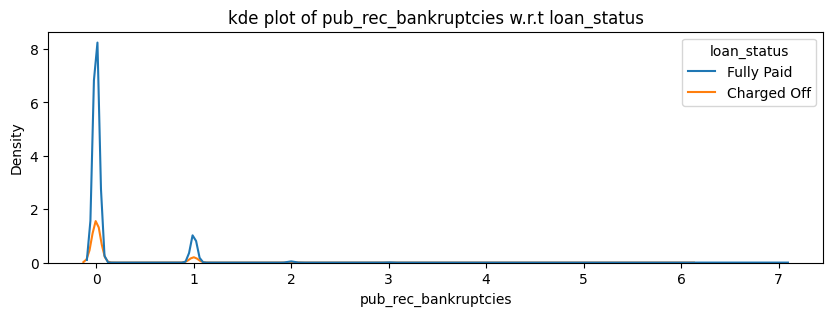

In [18]:
for col in numerical_columns:
    plot_kdeplot(df,col,'loan_status')

In [14]:
### Impute missing values in mor_acc
df['mort_acc'] = df['mort_acc'].fillna(df.groupby('total_acc')['mort_acc'].transform('median'))


In [15]:
df.isna().sum()/len(df)*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.768480
emp_length              4.624016
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000476
loan_status             0.000476
purpose                 0.000476
dti                     0.000476
earliest_cr_line        0.000476
open_acc                0.000476
pub_rec                 0.000476
revol_bal               0.000476
revol_util              0.070904
total_acc               0.000476
initial_list_status     0.000476
application_type        0.000476
mort_acc                0.000476
pub_rec_bankruptcies    0.138002
address                 0.000476
dtype: float64

In [16]:
df['emp_length'].value_counts()

emp_length
10+ years    67050
2 years      18889
< 1 year     16770
3 years      16740
5 years      14023
1 year       13749
4 years      12625
6 years      11109
7 years      11059
8 years      10156
9 years       8255
Name: count, dtype: int64

In [17]:
## drop emp_title column and null values from remianing columns
df=df.drop(columns=['emp_title'])
df = df.dropna()
df.isna().sum()/len(df)*100


loan_amnt               0.0
term                    0.0
int_rate                0.0
installment             0.0
grade                   0.0
sub_grade               0.0
emp_length              0.0
home_ownership          0.0
annual_inc              0.0
verification_status     0.0
issue_d                 0.0
loan_status             0.0
purpose                 0.0
dti                     0.0
earliest_cr_line        0.0
open_acc                0.0
pub_rec                 0.0
revol_bal               0.0
revol_util              0.0
total_acc               0.0
initial_list_status     0.0
application_type        0.0
mort_acc                0.0
pub_rec_bankruptcies    0.0
address                 0.0
dtype: float64

In [18]:
df['zip_code'] = df.address.apply(lambda x: x[-5:])
df['zip_code']

0         22690
1         05113
2         05113
3         00813
4         11650
          ...  
210136    93700
210137    22690
210138    29597
210139    00813
210140    48052
Name: zip_code, Length: 199992, dtype: object

In [19]:
df['city_code']=df.address.apply(lambda x: x[-8:-6])
df['city_code']

0         OK
1         SD
2         WV
3         MA
4         VA
          ..
210136    NC
210137    GA
210138    HI
210139    WA
210140    RI
Name: city_code, Length: 199992, dtype: object

In [20]:
df=df.drop(columns=['address'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199992 entries, 0 to 210140
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             199992 non-null  float64
 1   term                  199992 non-null  object 
 2   int_rate              199992 non-null  float64
 3   installment           199992 non-null  float64
 4   grade                 199992 non-null  object 
 5   sub_grade             199992 non-null  object 
 6   emp_length            199992 non-null  object 
 7   home_ownership        199992 non-null  object 
 8   annual_inc            199992 non-null  float64
 9   verification_status   199992 non-null  object 
 10  issue_d               199992 non-null  object 
 11  loan_status           199992 non-null  object 
 12  purpose               199992 non-null  object 
 13  dti                   199992 non-null  float64
 14  earliest_cr_line      199992 non-null  object 
 15  open_

In [21]:
df=df.drop(columns=['issue_d', 'earliest_cr_line'])
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code,city_code
0,10000.0,36 months,11.44,329.48,B,B4,10+ years,RENT,117000.0,Not Verified,...,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,22690,OK
1,8000.0,36 months,11.99,265.68,B,B5,4 years,MORTGAGE,65000.0,Not Verified,...,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,05113,SD
2,15600.0,36 months,10.49,506.97,B,B3,< 1 year,RENT,43057.0,Source Verified,...,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,05113,WV
3,7200.0,36 months,6.49,220.65,A,A2,6 years,RENT,54000.0,Not Verified,...,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,00813,MA
4,24375.0,60 months,17.27,609.33,C,C5,9 years,MORTGAGE,55000.0,Verified,...,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,11650,VA


In [22]:
categorical_columns = list(df.loc[:, df.dtypes==object].columns)
# check number of categories in each featue
for col in categorical_columns:
    print(f"{col}-->{df[col].nunique()}")


term-->2
grade-->7
sub_grade-->35
emp_length-->11
home_ownership-->6
verification_status-->3
loan_status-->2
purpose-->14
initial_list_status-->2
application_type-->3
zip_code-->10
city_code-->54


In [23]:
from scipy.stats import chi2_contingency
 
for col in categorical_columns:
    res=chi2_contingency(pd.crosstab(df[col],df['loan_status']).values)
    print(f"{col}: {res.pvalue}")
     


term: 0.0
grade: 0.0
sub_grade: 0.0
emp_length: 3.97703344715202e-09
home_ownership: 1.1430340487102007e-189
verification_status: 1.269819130332062e-286
loan_status: 0.0
purpose: 2.149484719924426e-157
initial_list_status: 1.5931343240971335e-05
application_type: 1.5294085522258861e-06
zip_code: 0.0
city_code: 0.4497225040813663


In [24]:
# remove city_code column as it is having pvalu>0.05
df = df.drop(columns=['city_code'])

df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code
0,10000.0,36 months,11.44,329.48,B,B4,10+ years,RENT,117000.0,Not Verified,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,22690
1,8000.0,36 months,11.99,265.68,B,B5,4 years,MORTGAGE,65000.0,Not Verified,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,05113
2,15600.0,36 months,10.49,506.97,B,B3,< 1 year,RENT,43057.0,Source Verified,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,05113
3,7200.0,36 months,6.49,220.65,A,A2,6 years,RENT,54000.0,Not Verified,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,00813
4,24375.0,60 months,17.27,609.33,C,C5,9 years,MORTGAGE,55000.0,Verified,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,11650


<Axes: >

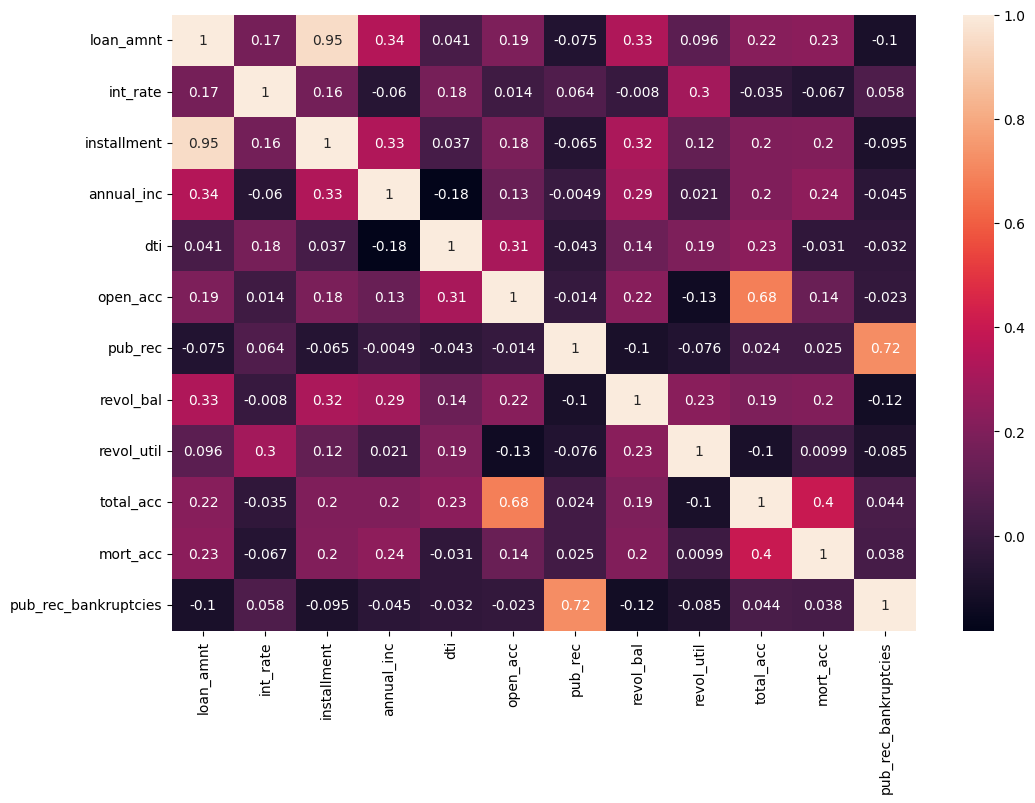

In [25]:
# plot correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(data=df.loc[:, numerical_columns].corr(method='pearson'),annot=True)

In [26]:
## very high correlation between loan mount and installment columns
# let's remove installment feature 
df = df.drop(columns=['installment'])

In [28]:
# categorical_columns.remove('city_code')
# categorical_columns
# numerical_columns.remove('installment')
numerical_columns, categorical_columns

(['loan_amnt',
  'int_rate',
  'annual_inc',
  'dti',
  'open_acc',
  'pub_rec',
  'revol_bal',
  'revol_util',
  'total_acc',
  'mort_acc',
  'pub_rec_bankruptcies'],
 ['term',
  'grade',
  'sub_grade',
  'emp_length',
  'home_ownership',
  'verification_status',
  'loan_status',
  'purpose',
  'initial_list_status',
  'application_type',
  'zip_code'])

In [29]:
df['term']=df['term'].str.strip()


In [30]:
for col in categorical_columns:
    print(f"{col}--> {df[col].unique()}--> {df[col].nunique()}")



term--> ['36 months' '60 months']--> 2
grade--> ['B' 'A' 'C' 'E' 'D' 'F' 'G']--> 7
sub_grade--> ['B4' 'B5' 'B3' 'A2' 'C5' 'C3' 'A1' 'B2' 'C1' 'A5' 'E4' 'A4' 'A3' 'D1'
 'C2' 'B1' 'D3' 'D5' 'D2' 'E1' 'E2' 'E5' 'F4' 'E3' 'D4' 'G1' 'F5' 'G2'
 'C4' 'F1' 'F3' 'G5' 'G4' 'F2' 'G3']--> 35
emp_length--> ['10+ years' '4 years' '< 1 year' '6 years' '9 years' '2 years' '3 years'
 '8 years' '7 years' '5 years' '1 year']--> 11
home_ownership--> ['RENT' 'MORTGAGE' 'OWN' 'OTHER' 'ANY' 'NONE']--> 6
verification_status--> ['Not Verified' 'Source Verified' 'Verified']--> 3
loan_status--> ['Fully Paid' 'Charged Off']--> 2
purpose--> ['vacation' 'debt_consolidation' 'credit_card' 'home_improvement'
 'small_business' 'major_purchase' 'other' 'medical' 'wedding' 'car'
 'moving' 'house' 'educational' 'renewable_energy']--> 14
initial_list_status--> ['w' 'f']--> 2
application_type--> ['INDIVIDUAL' 'JOINT' 'DIRECT_PAY']--> 3
zip_code--> ['22690' '05113' '00813' '11650' '30723' '70466' '29597' '48052' '86630'
 '9

In [31]:
## Encode grade and sub_grade using label encoder as these features are ordinal and remaining_features using one hot encoder
label_encoder_grade=LabelEncoder()
label_encoded_features=label_encoder_grade.fit_transform(df['grade'].values)

In [32]:
label_encoder_subgrade=LabelEncoder()
label_encoded_subgrade=label_encoder_subgrade.fit_transform(df['sub_grade'].values)


In [33]:
le_emp_length=LabelEncoder()
label_encoded_emp_length = le_emp_length.fit_transform(df['emp_length'].values)

In [34]:
df['emp_length'].values.shape

(199992,)

In [35]:
ohe=OneHotEncoder(drop=['36 months','RENT','Not Verified','vacation','w','INDIVIDUAL','22690'])
ohe_encoded_features = ohe.fit_transform(df[['term','home_ownership','verification_status','purpose','initial_list_status','application_type','zip_code']]).toarray()

In [38]:
ohe_encoded_features[1]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [61]:
# ohe.inverse_transform(np.array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
#        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]).reshape(1,-1))

ohe.transform(np.array([['60 months', 'RENT', 'Verified', 'vacation',
        'f', 'INDIVIDUAL', '22690']])).toarray()

d:\LoanTap\LoanTap\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


array([[1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

In [36]:
ohe.get_feature_names_out()

array(['term_60 months', 'home_ownership_ANY', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER',
       'home_ownership_OWN', 'verification_status_Source Verified',
       'verification_status_Verified', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy',
       'purpose_small_business', 'purpose_wedding',
       'initial_list_status_f', 'application_type_DIRECT_PAY',
       'application_type_JOINT', 'zip_code_00813', 'zip_code_05113',
       'zip_code_11650', 'zip_code_29597', 'zip_code_30723',
       'zip_code_48052', 'zip_code_70466', 'zip_code_86630',
       'zip_code_93700'], dtype=object)

In [37]:
ohe_data=pd.DataFrame(ohe_encoded_features, columns=ohe.get_feature_names_out())
ohe_data.head()

,term_60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,...,application_type_JOINT,zip_code_00813,zip_code_05113,zip_code_11650,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
label_encoder_grade.transform(['A']).shape

(1,)

In [38]:
le_data=pd.DataFrame({'le_grade':label_encoded_features.reshape(-1,), 
                      'le_subgrade':label_encoded_subgrade.reshape(-1,),
                      'le_emp_length':label_encoded_emp_length.reshape(-1,)})
le_data.head()



,le_grade,le_subgrade,le_emp_length
0,1,8,1
1,1,9,4
2,1,7,10
3,0,1,6
4,2,14,9


In [39]:
df.reset_index(inplace=True)
final_data = pd.concat([df,ohe_data, le_data], axis=1)
final_data.shape

(199992, 59)

In [40]:
X= final_data.drop(columns=categorical_columns)
y = final_data[['loan_status']]

In [41]:
X.head()

,index,loan_amnt,int_rate,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,zip_code_11650,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700,le_grade,le_subgrade,le_emp_length
0,0,10000.0,11.44,117000.0,26.24,16.0,0.0,36369.0,41.8,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8,1
1,1,8000.0,11.99,65000.0,22.05,17.0,0.0,20131.0,53.3,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,9,4
2,2,15600.0,10.49,43057.0,12.79,13.0,0.0,11987.0,92.2,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,10
3,3,7200.0,6.49,54000.0,2.60,6.0,0.0,5472.0,21.5,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,6
4,4,24375.0,17.27,55000.0,33.95,13.0,0.0,24584.0,69.8,43.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,14,9


In [42]:
y['loan_status']=y['loan_status'].apply(lambda x: 1 if x=='Charged Off' else 0)

C:\Users\Sail\AppData\Local\Temp\ipykernel_27260\492567033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['loan_status']=y['loan_status'].apply(lambda x: 1 if x=='Charged Off' else 0)


In [43]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

In [44]:
sc = StandardScaler()
x_train_scaled=sc.fit_transform(x_train)


In [45]:
lr = LogisticRegression()
lr.fit(x_train_scaled, y_train)

d:\LoanTap\LoanTap\venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [46]:
x_test_scaled=sc.transform(x_test)


In [47]:
y_pred=lr.predict(x_test_scaled)
acc=accuracy_score(y_test,y_pred)

In [48]:
acc

0.8886722168054202

In [49]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[31983   357]
 [ 4096  3563]]


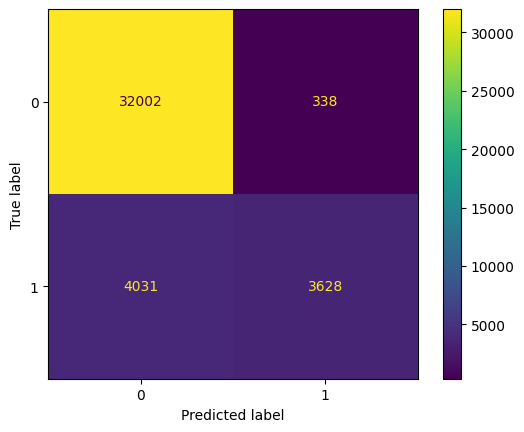

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(cm,
                           display_labels=lr.classes_)
disp.plot()

In [50]:
## lets check classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.93     32340
           1       0.91      0.47      0.62      7659

    accuracy                           0.89     39999
   macro avg       0.90      0.73      0.78     39999
weighted avg       0.89      0.89      0.87     39999



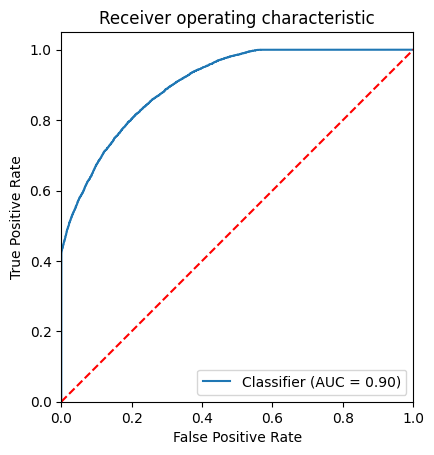

In [51]:
#Plot ROC curve
RocCurveDisplay.from_predictions(y_test, lr.predict_proba(x_test_scaled)[:,1],drop_intermediate=False)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Precision and Recall Curve')

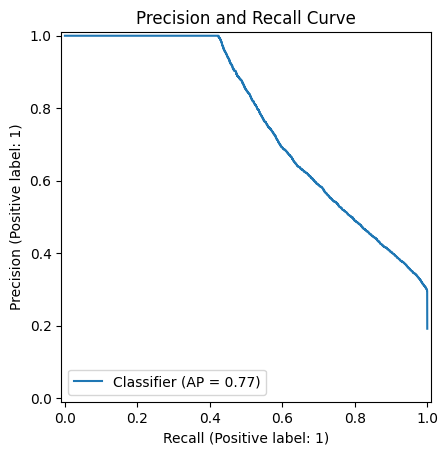

In [52]:
# As we have class imbalance in dataset and we know that ROC curve doesn't perform well with imbalance dataset 
# we can plot precision recall curve 
PrecisionRecallDisplay.from_predictions(y_test,lr.predict_proba(x_test_scaled)[:,1] )  
plt.title('Precision and Recall Curve')

In [53]:
# We have got the accuracy of 0.891 but our recall for positive class is less
#Low recall means high number of false negatives i.e. our model is predicting defauletrs as non defaulters
#let's check how we can improve this score further
#Let's check if there is any Multi colinearity present in data, we will VIF to check this
def calc_vif(X):
    # Calculating the VIF
    vif=pd.DataFrame()
    vif['Feature']=X.columns
    vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF']=round(vif['VIF'],2)
    vif=vif.sort_values(by='VIF',ascending=False)
    return vif

VIF_res = calc_vif(X)


In [54]:
VIF_res

,Feature,VIF
2,int_rate,185.12
46,le_subgrade,160.62
45,le_grade,64.34
22,purpose_debt_consolidation,31.72
9,total_acc,13.08
5,open_acc,12.75
21,purpose_credit_card,11.83
8,revol_util,7.98
4,dti,7.41
1,loan_amnt,6.42


In [55]:
X.drop(columns=['int_rate'], inplace=True)
VIF_res = calc_vif(X)
VIF_res.head()


,Feature,VIF
45,le_subgrade,88.37
44,le_grade,64.25
21,purpose_debt_consolidation,18.17
8,total_acc,13.08
4,open_acc,12.72


In [62]:
X.drop(columns=['le_subgrade'], inplace=True)
VIF_res = calc_vif(X)
VIF_res.head()


,Feature,VIF
21,purpose_debt_consolidation,17.33
8,total_acc,13.08
4,open_acc,12.71
7,revol_util,7.69
3,dti,7.40


In [63]:
X.drop(columns=['purpose_debt_consolidation'], inplace=True)
VIF_res = calc_vif(X)
VIF_res.head()


,Feature,VIF
8,total_acc,12.97
4,open_acc,12.37
3,dti,7.04
7,revol_util,6.80
1,loan_amnt,6.20


In [64]:
X.drop(columns=['total_acc'], inplace=True)
VIF_res = calc_vif(X)
VIF_res.head()


,Feature,VIF
3,dti,6.91
4,open_acc,6.90
7,revol_util,6.80
1,loan_amnt,6.19
42,le_grade,4.59


In [69]:
X_scaled = sc.fit_transform(X)
X_train, X_test, y_train, y_test =train_test_split(X_scaled,y,test_size=0.20,stratify=y)

In [73]:
sm=SMOTE(random_state=42)
X_train_res,y_train_res=sm.fit_resample(X_train,y_train['loan_status'])

In [74]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (258714, 44)
After OverSampling, the shape of train_y: (258714,) 

After OverSampling, counts of label '1': 129357
After OverSampling, counts of label '0': 129357


In [75]:
lr1 = LogisticRegression(max_iter=1000)
lr1.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000)

In [76]:
prediction = lr1.predict(X_test)

In [77]:
lr1.score(X_test, y_test)

0.8108702717567939

[[26380  5960]
 [ 1605  6054]]


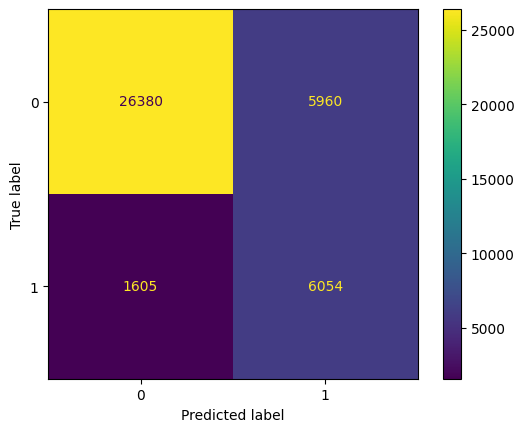

In [78]:
cm1=confusion_matrix(y_test,prediction)
print(cm1)
disp = ConfusionMatrixDisplay(cm1,
                           display_labels=lr1.classes_)
disp.plot()

In [79]:
## lets check classification report
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.94      0.82      0.87     32340
           1       0.50      0.79      0.62      7659

    accuracy                           0.81     39999
   macro avg       0.72      0.80      0.75     39999
weighted avg       0.86      0.81      0.82     39999



Text(0.5, 1.0, 'Precision and Recall Curve')

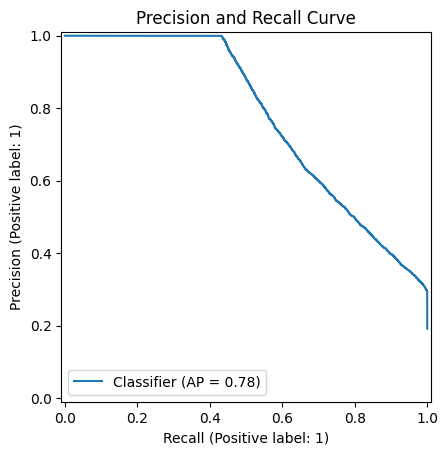

In [80]:
PrecisionRecallDisplay.from_predictions(y_test,lr1.predict_proba(X_test)[:,1] )  
plt.title('Precision and Recall Curve')

In [67]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')